In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, 
roc_curve, precision_recall_curve,roc_auc_score,accuracy_score)
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler,SMOTE
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
warnings.filterwarnings("ignore")
sns.set()
%matplotlib inline

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
data_dir ='../input/wayfair/'
test = pd.read_csv(data_dir + 'df_holdout_scholarjet.csv',index_col = 0)
train = pd.read_csv(data_dir + 'df_training_scholarjet.csv',index_col = 0)

In [3]:
test.head()

,cuid,roll_up,currentstatus,companytypegroup,team,customersource,accrole,num_employees,num_purchases_year,cost_purchases_year,...,percemailopenedyearsixty,percemailclickedone,percemailclickedthreeone,percemailclickedseventhree,percemailclickedthirtyseven,percemailclickedsixtythirty,percemailclickedyearsixty,currentapplicability,numemaillist,dayssinceenrollment
0,16838,Onboarding,Enrolled,Business,US,Internal Application,None,1,1to2,lessthan1,...,0.025806,0.0,0.0,0.0,0.021739,0.012821,0.032258,5.0,2.0,86
1,532175,Onboarding,Enrolled,Business,US,Search - Paid,None,6to10,None,None,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,3
2,532176,Onboarding,Enrolled,Business,US,Internal Application,None,11to50,3to5,1to5,...,0.036190,0.0,0.0,0.0,0.000000,0.000000,0.015238,8.0,4.0,13
3,532187,Onboarding,Enrolled,Business,US,Internal Application,Primary,None,None,None,...,1.000000,0.0,0.0,0.5,0.272727,0.250000,0.000000,NaN,NaN,10
4,16938,Onboarding,Enrolled,Trade,US,Internal Customer Scrape,Primary,None,None,None,...,0.049383,0.5,0.0,0.0,0.000000,0.043478,0.016461,5.0,2.0,42


In [4]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols + one_value_cols_test))

print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)


57 features are going to be dropped for being useless


In [5]:
for col in tqdm_notebook(train.columns): 
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values)) 

In [6]:
X_c = train.drop(['cuid', 'convert_30', 'revenue_30'], axis=1)
y_c = train['convert_30']
X_c.fillna(-999, inplace=True)
test = test.drop(['cuid'], axis=1)
test.fillna(-999, inplace=True)

In [7]:
useful_features = ['numordersixtythirty', 'percsecondsinbound', 'percdirtythirty', 'numatcthirtyseven', 'numorderthreeone', 'sumatcprice', 'currentstatus', 'numatcyearsixty', 'percemailclickedthirtyseven', 'numstores', 'numideaboardyearsixty', 'totalcalldurationthirtyseven', 'numtotalpageviewsthirtyseven', 'pospercentage', 'numatcseventhree', 'percentresolved', 'accrole', 'numideaboardseventhree', 'numvisitseventhree', 'numvisitthirtyseven', 'avgatcprice', 'percemailopenedsixtythirty', 'numinf', 'numskusviewedseventhree', 'numsearchtermsyearsixty', 'avgpricesixtythirty', 'totalrev', 'sumrevsixtythirty', 'numskusviewedone', 'numselforder', 'numinfphone', 'cuidshare', 'avgpriceyearsixty', 'numtotalpageviewsthreeone', 'totalcalldurationyearsixty', 'numinfconnect', 'numtotalpageviewsseventhree', 'numcallsthirtyseven', 'numloggedinthirtyseven', 'dayssincelastvisit', 'numsecondsonsitethreeone', 'sumrevyearsixty', 'numtotalpageviewsone', 'numloggedinone', 'numsecondsonsitesixtythirty', 'numtasksfirstintrosixtythirty', 'roll_up', 'dayssincelastord', 'numloggedinyearsixty', 'numorderseventhree', 'numinfquote', 'numskusviewedthirtyseven', 'sumrevthreeone', 'numreturn', 'numemaillist', 'numloggedinseventhree', 'percdirtyninetythirty', 'numsecondsonsiteone', 'numbamorder', 'percemailopenedthreeone', 'numorderyearsixty', 'numemailsthirtyseven', 'numother', 'numloggedinthreeone', 'numatcthreeone', 'numideaboardsixtythirty', 'numvisitone', 'numcallssixtythirty', 'num_purchases_year', 'numloggedinsixtythirty', 'numsecondsonsiteseventhree', 'cost_purchases_year', 'percemailopenedseventhree', 'percemailclickedsixtythirty', 'numorderthirtyseven', 'numvisitsixtythirty', 'numwims', 'numsecondsonsitethirtyseven', 'sumrevseventhree', 'numvisittotal', 'numsearchtermsthreeone', 'sumrevthirtyseven', 'numtotalpageviewssixtythirty', 'aov', 'numcallsyearsixty', 'numsecondsonsiteyearsixty', 'numemailsyearsixty', 'totalcalldurationsixtythirty', 'avgprice', 'numsearchtermsseventhree', 'percemailopenedone', 'numemailssixtythirty', 'numorderone', 'numsearchtermssixtythirty', 'percemailopenedyearsixty', 'numsearchtermsone', 'numskusviewedsixtythirty', 'enrollmentmethod', 'numvisityearsixty', 'percdirtyyearninety', 'numtotalpageviewsyearsixty', 'num_employees', 'numproblem', 'percemailopenedthirtyseven', 'numvisitthreeone', 'sumrevone', 'currentapplicability', 'customersource', 'numatcsixtythirty', 'numbilling', 'numtasksfirstintroyearsixty', 'percentlarge', 'avgpriceseventhree', 'dayssinceenrollment', 'numsearchtermsthirtyseven', 'numideaboardthirtyseven', 'numskusviewedthreeone', 'avgpricethirtyseven', 'companytypegroup', 'numskusviewedyearsixty', 'numtasksfirstintrothirtyseven', 'avgpricethreeone', 'percemailclickedyearsixty']

In [8]:
cols_to_drop = [col for col in train.columns if col not in useful_features]
cols_to_drop.remove('convert_30')
cols_to_drop.remove('cuid')
cols_to_drop.remove('revenue_30')

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

X_final = train.drop(['cuid', 'convert_30', 'revenue_30'], axis=1)
y_final = train['convert_30']

# Tuning ！Based on SKlearn API

In [9]:
#Lightbgm
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

parameters_l = {
              'max_depth': st.randint(3, 40),
              'learning_rate': st.uniform(0.05, 0.4),
              'n_estimators': st.randint(3, 100),
                'max_depth': st.randint(3, 40),
              'feature_fraction': one_to_left,
              'bagging_fraction':one_to_left,
              'bagging_freq': st.randint(3, 40),
              'lambda_l1': one_to_left,
              'lambda_l2': one_to_left,
              'min_data_in_leaf': st.randint(3, 200),
                'cat_smooth':st.randint(3, 40),
    'num_leaves':st.randint(300, 700),
    'subsample_for_bin':st.randint(3, 100),
    'min_split_gain': from_zero_positive,
          'min_child_weight': one_to_left,
          'min_child_samples': st.randint(3, 40),
    'reg_alpha': one_to_left,
          'reg_lambda': one_to_left,
    'subsample_for_bin':st.randint(5000, 15000),
    'n_estimators' : st.randint(3, 500),
    #'num_boost_round':st.randint(3, 200)
    
}

llf = lgb.LGBMClassifier(silent=True,
            nthread=-1,boosting_type='gbdt',
                        objective = 'binary',
                         metric = 'auc',
            seed=224)



gs1 = RandomizedSearchCV(llf, parameters_l, n_jobs=1,verbose=1,cv=5,scoring='roc_auc')  
gs1.fit(X_final, y_final)  
gs1.best_estimator_

print("Best score: %0.3f" % gs1.best_score_)
print("Best parameters set:")
best_parameters1 = gs1.best_estimator_.get_params()
for param_name in sorted(parameters_l.keys()):
    print("\t%s: %r" % (param_name, best_parameters1[param_name]))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.2min finished


Best score: 0.795
Best parameters set:
	bagging_fraction: 0.9682162621375133
	bagging_freq: 20
	cat_smooth: 7
	feature_fraction: 0.9372521836328631
	lambda_l1: 0.945123649258793
	lambda_l2: 0.9575209894450787
	learning_rate: 0.1856237122383263
	max_depth: 3
	min_child_samples: 11
	min_child_weight: 0.9937653339965747
	min_data_in_leaf: 10
	min_split_gain: 39.09392644786998
	n_estimators: 12
	num_leaves: 437
	reg_alpha: 0.9023628584133238
	reg_lambda: 0.954139975288108
	subsample_for_bin: 12739


In [10]:
#xgbosst
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

parameters_x = {
              'max_depth': st.randint(3, 40),
              'learning_rate': st.uniform(0.05, 0.4),
              'n_estimators': st.randint(3, 100),
                'max_depth': st.randint(3, 40),
              'feature_fraction': one_to_left,
              'bagging_fraction':one_to_left,
              'bagging_freq': st.randint(3, 40),
              'lambda_l1': one_to_left,
              'lambda_l2': one_to_left,
              'min_data_in_leaf': st.randint(3, 200),
                'cat_smooth':st.randint(3, 40),
    'num_leaves':st.randint(300, 700),
    'subsample_for_bin':st.randint(3, 100),
    'min_split_gain': from_zero_positive,
          'min_child_weight': one_to_left,
          'min_child_samples': st.randint(3, 40),
    'reg_alpha': one_to_left,
          'reg_lambda': one_to_left,
    'subsample_for_bin':st.randint(5000, 15000),
    'n_estimators' : st.randint(3, 500),
    #'num_boost_round':st.randint(3, 200)
    
}


xlf = xgb.XGBClassifier(silent=True,
            nthread=-1,
            colsample_bylevel=1,
            seed=224)



gs = RandomizedSearchCV(xlf, parameters_x, n_jobs=1,verbose=1,cv=5,scoring='roc_auc')  
gs.fit(X_final, y_final)  
gs.best_estimator_

print("Best score: %0.3f" % gs.best_score_)
print("Best parameters set:")
best_parameters = gs.best_estimator_.get_params()
for param_name in sorted(parameters_x.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
best_parameters['eval_metric'] = 'auc'

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 33.1min finished


Best score: 0.778
Best parameters set:
	bagging_fraction: 0.9125971333954608
	bagging_freq: 14
	cat_smooth: 16
	feature_fraction: 0.5964373246038916
	lambda_l1: 0.8843951170839366
	lambda_l2: 0.9605536811501525
	learning_rate: 0.05280964061679683
	max_depth: 35
	min_child_samples: 18
	min_child_weight: 0.925572629781502
	min_data_in_leaf: 30
	min_split_gain: 121.53193352910685
	n_estimators: 371
	num_leaves: 658
	reg_alpha: 0.9395804571664889
	reg_lambda: 0.6280778866615849
	subsample_for_bin: 8395


In [11]:
0.780
{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.19036828175701154,
 'max_delta_step': 0,
 'max_depth': 7,
 'min_child_weight': 0.7306208683297236,
 'missing': None,
 'n_estimators': 47,
 'n_jobs': 1,
 'nthread': -1,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0.7480809843590676,
 'reg_lambda': 0.8293639075272718,
 'scale_pos_weight': 1,
 'seed': 224,
 'silent': True,
 'subsample': 1,
 'verbosity': 1,
 'bagging_fraction': 0.9097415418715779,
 'bagging_freq': 13,
 'cat_smooth': 4,
 'feature_fraction': 0.9316946240027555,
 'lambda_l1': 0.9915717947239997,
 'lambda_l2': 0.8555027170501156,
 'min_child_samples': 5,
 'min_data_in_leaf': 49,
 'min_split_gain': 8.167213498258883,
 'num_leaves': 326,
 'subsample_for_bin': 7389}

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.19036828175701154,
 'max_delta_step': 0,
 'max_depth': 7,
 'min_child_weight': 0.7306208683297236,
 'missing': None,
 'n_estimators': 47,
 'n_jobs': 1,
 'nthread': -1,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0.7480809843590676,
 'reg_lambda': 0.8293639075272718,
 'scale_pos_weight': 1,
 'seed': 224,
 'silent': True,
 'subsample': 1,
 'verbosity': 1,
 'bagging_fraction': 0.9097415418715779,
 'bagging_freq': 13,
 'cat_smooth': 4,
 'feature_fraction': 0.9316946240027555,
 'lambda_l1': 0.9915717947239997,
 'lambda_l2': 0.8555027170501156,
 'min_child_samples': 5,
 'min_data_in_leaf': 49,
 'min_split_gain': 8.167213498258883,
 'num_leaves': 326,
 'subsample_for_bin': 7389}

In [12]:
#Catboost
from catboost import CatBoostClassifier, Pool

parameters_c = {
              'max_depth': st.randint(3, 40),
              'learning_rate': st.uniform(0.05, 0.4),
              'n_estimators': st.randint(3, 100),
                'max_depth': st.randint(3, 40),
              'feature_fraction': one_to_left,
              'bagging_fraction':one_to_left,
              'bagging_freq': st.randint(3, 40),
              'lambda_l1': one_to_left,
              'lambda_l2': one_to_left,
              'min_data_in_leaf': st.randint(3, 200),
                'cat_smooth':st.randint(3, 40),
    'num_leaves':st.randint(300, 700),
    'subsample_for_bin':st.randint(3, 100),
    'min_split_gain': from_zero_positive,
          'min_child_weight': one_to_left,
          'min_child_samples': st.randint(3, 40),
    'reg_alpha': one_to_left,
          'reg_lambda': one_to_left,
    'subsample_for_bin':st.randint(5000, 15000),
    'n_estimators' : st.randint(3, 500),
    #'num_boost_round':st.randint(3, 200)
    
}


clf = CatBoostClassifier(silent=True,boosting_type='gbdt',
                        objective = 'binary')



gs2 = RandomizedSearchCV(llf, parameters_l, n_jobs=1,verbose=1,cv=5,scoring='roc_auc')  
gs2.fit(X_final, y_final)  
gs2.best_estimator_

print("Best score: %0.3f" % gs1.best_score_)
print("Best parameters set:")
best_parameters2 = gs2.best_estimator_.get_params()
for param_name in sorted(parameters_c.keys()):
    print("\t%s: %r" % (param_name, best_parameters2[param_name]))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   58.6s finished


Best score: 0.795
Best parameters set:
	bagging_fraction: 0.8918713727374278
	bagging_freq: 19
	cat_smooth: 29
	feature_fraction: 0.8894823603195078
	lambda_l1: 0.9526641941645452
	lambda_l2: 0.830725954378938
	learning_rate: 0.08305017754138552
	max_depth: 21
	min_child_samples: 20
	min_child_weight: 0.9783079181526664
	min_data_in_leaf: 121
	min_split_gain: 9.706947173686679
	n_estimators: 425
	num_leaves: 467
	reg_alpha: 0.7009006791438923
	reg_lambda: 0.9213958709749238
	subsample_for_bin: 13771


In [13]:
Best score: 0.798
Best parameters set:
	bagging_fraction: 0.8004665229889304
	bagging_freq: 25
	cat_smooth: 12
	feature_fraction: 0.8393400222782162
	lambda_l1: 0.9682053284739619
	lambda_l2: 0.9017436761236722
	learning_rate: 0.055260509394571194
	max_depth: 33
	min_child_samples: 21
	min_child_weight: 0.9587582815725624
	min_data_in_leaf: 69
	min_split_gain: 14.19598323851757
	n_estimators: 352
	num_leaves: 602
	reg_alpha: 0.8727188930006153
	reg_lambda: 0.9222133077641127
	subsample_for_bin: 10707

SyntaxError: invalid syntax (<ipython-input-13-b3db918e019f>, line 1)

In [14]:
# Light
folds = KFold(n_splits=5,shuffle = True)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_final.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X_final, y_final)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X_final.iloc[trn_idx], label=y_final.iloc[trn_idx])
    val_data = lgb.Dataset(X_final.iloc[test_idx], label=y_final.iloc[test_idx])
    clf = lgb.train(best_parameters1, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
Did not meet early stopping. Best iteration is:
[12]	training's auc: 0.816973	valid_1's auc: 0.798167
Fold 1 finished in 0:00:00.446064
Training on fold 2
Training until validation scores don't improve for 500 rounds.
Did not meet early stopping. Best iteration is:
[12]	training's auc: 0.812925	valid_1's auc: 0.807733
Fold 2 finished in 0:00:00.450469
Training on fold 3
Training until validation scores don't improve for 500 rounds.
Did not meet early stopping. Best iteration is:
[12]	training's auc: 0.814177	valid_1's auc: 0.818648
Fold 3 finished in 0:00:00.444196
Training on fold 4
Training until validation scores don't improve for 500 rounds.
Did not meet early stopping. Best iteration is:
[12]	training's auc: 0.818129	valid_1's auc: 0.796699
Fold 4 finished in 0:00:00.444639
Training on fold 5
Training until validation scores don't improve for 500 rounds.
Did not meet early stopping. Best iteration is

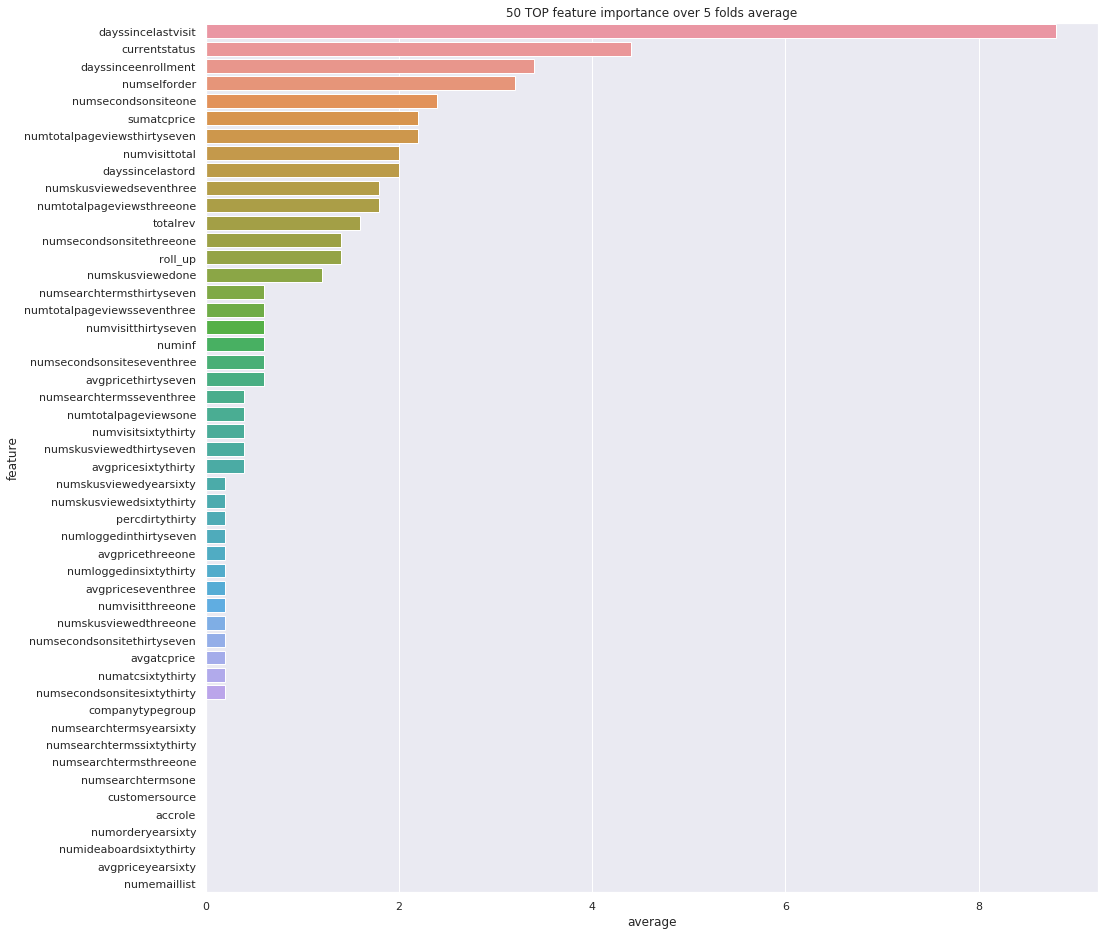

In [15]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('lgmfeature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [16]:

folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances2 = pd.DataFrame()
feature_importances2['feature'] = X_final.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X_final, y_final)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = xgb.DMatrix(X_final.iloc[trn_idx], label=y_final.iloc[trn_idx])
    val_data = xgb.DMatrix(X_final.iloc[test_idx], label=y_final.iloc[test_idx])
    clf2 = xgb.train(best_parameters, trn_data, 10000, evals=[(val_data,'valid'), (trn_data,'train')], 
                     verbose_eval=1000, early_stopping_rounds=500)
    
    #feature_importances2['fold_{}'.format(fold + 1)] = list(clf2.get_score(importance_type='weight').values())
    aucs.append(clf2.best_score)
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
[0]	valid-auc:0.691972	train-auc:0.834239
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 500 rounds.
Stopping. Best iteration:
[141]	valid-auc:0.787416	train-auc:1

Fold 1 finished in 0:00:58.295528
Training on fold 2
[0]	valid-auc:0.675901	train-auc:0.866786
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 500 rounds.
Stopping. Best iteration:
[279]	valid-auc:0.743654	train-auc:1

Fold 2 finished in 0:02:31.400564
Training on fold 3
[0]	valid-auc:0.732124	train-auc:0.871444
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 500 rounds.
Stopping. Best iteration:
[171]	valid-auc:0.78034	train-auc:1

Fold 3 finished in 0:04:18.452007
Training on fold 4
[0]	valid-auc:0.761834	train-auc:0.853255
Multiple eval metrics have been

<Figure size 1152x1152 with 0 Axes>

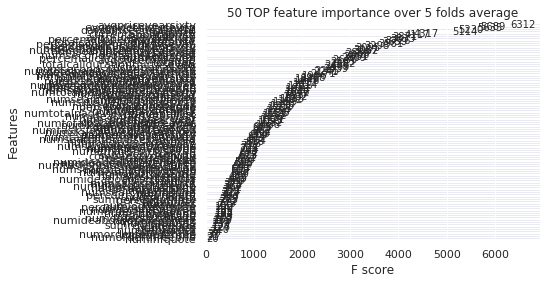

In [17]:
#feature_importances2['average'] = feature_importances2[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
#feature_importances2.to_csv('xgmfeature_importances.csv')
plt.figure(figsize=(16, 16))
#sns.barplot(data=feature_importances2.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
xgb.plot_importance(clf2)
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [18]:

folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances3 = pd.DataFrame()
feature_importances3['feature'] = X_final.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X_final, y_final)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = Pool(X_final.iloc[trn_idx], label=y_final.iloc[trn_idx])
    val_data = Pool(X_final.iloc[test_idx], label=y_final.iloc[test_idx])
    model = CatBoostClassifier(learning_rate=0.03,
                           eval_metric='AUC')

    model.fit(X_final.iloc[trn_idx],y_final.iloc[trn_idx],eval_set=val_data, verbose_eval=1000, early_stopping_rounds=500)
    print(model.get_best_score())


Training on fold 1
0:	test: 0.6186705	best: 0.6186705 (0)	total: 116ms	remaining: 1m 55s
999:	test: 0.7930828	best: 0.7962868 (642)	total: 1m 5s	remaining: 0us

bestTest = 0.7962868158
bestIteration = 642

Shrink model to first 643 iterations.
{'learn': {'Logloss': 0.26477285634358516}, 'validation': {'Logloss': 0.3274138670934064, 'AUC': 0.7962868157767407}}
Training on fold 2
0:	test: 0.6725828	best: 0.6725828 (0)	total: 94ms	remaining: 1m 33s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.766621825
bestIteration = 298

Shrink model to first 299 iterations.
{'learn': {'Logloss': 0.2881651604541908}, 'validation': {'Logloss': 0.3443863092048248, 'AUC': 0.7666218250414436}}
Training on fold 3
0:	test: 0.7292323	best: 0.7292323 (0)	total: 122ms	remaining: 2m 2s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8197957665
bestIteration = 336

Shrink model to first 337 iterations.
{'learn': {'Logloss': 0.30275130081586116}, 'validation': {'Logloss'

Final light

In [19]:
best_iter = clf.best_iteration
clff = lgb.LGBMClassifier(**best_parameters1, num_boost_round=best_iter)
clff.fit(X_final, y_final)

LGBMClassifier(bagging_fraction=0.9682162621375133, bagging_freq=20,
               boosting_type='gbdt', cat_smooth=7, class_weight=None,
               colsample_bytree=1.0, feature_fraction=0.9372521836328631,
               importance_type='split', lambda_l1=0.945123649258793,
               lambda_l2=0.9575209894450787, learning_rate=0.1856237122383263,
               max_depth=3, metric='auc', min_child_samples=11,
               min_child_weight=0.9937653339965747, min_data_in_leaf=10,
               min_split_gain=39.09392644786998, n_estimators=12, n_jobs=-1,
               nthread=-1, num_boost_round=12, num_leaves=437,
               objective='binary', random_state=None,
               reg_alpha=0.9023628584133238, reg_lambda=0.954139975288108,
               seed=224, silent=True, subsample=1.0, subsample_for_bin=12739, ...)

In [20]:
sub = pd.read_csv(data_dir + 'df_holdout_scholarjet.csv',index_col = 0)
test.fillna(-999, inplace=True)
sub['convert_30'] = clff.predict(test)

In [21]:
answer1 = sub[['cuid','convert_30']]

In [22]:
answer1.to_csv('light.csv')
